We will be exploring the effects of resampling on Bagging and Boosting Algorithms and their performance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,balanced_accuracy_score,roc_auc_score,classification_report,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier

from sklearn.preprocessing import MinMaxScaler

from imblearn.datasets import fetch_datasets

from imblearn.under_sampling import RandomUnderSampler

from imblearn.over_sampling import SMOTE

from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier,RUSBoostClassifier,EasyEnsembleClassifier

In [3]:
# resampling methods dictionaries

resampling_dict={'random': RandomUnderSampler(random_state=50,replacement=False) ,
                'smote': SMOTE(random_state=50,k_neighbors=5,n_jobs=-1) }

In [4]:
# ensemble methods dictionary

ensemble_dict={  #RandomForest(Random Forest + undersampling)
                'balancedRF':BalancedRandomForestClassifier(n_estimators=20,criterion='gini',
                                                           max_depth=3,sampling_strategy='auto',
                                                           n_jobs=-1,random_state=50),
                
                # Bagging of Logistic Regression (no resampling)              
               'logit_bag':BaggingClassifier(base_estimator=LogisticRegression(random_state=50),
                                        n_estimators=20,n_jobs=-1,random_state=50),
    
                # Bagging of Logistic Regression (with resampling)
                'logit_balance':BalancedBaggingClassifier(base_estimator=LogisticRegression(random_state=50),
                                                         n_estimators=20,n_jobs=-1,random_state=50,
                                                         sampling_strategy='auto',max_features=1.0,
                                                         max_samples=1.0),
    
                # boosting+undersampling
                'rusboost':RUSBoostClassifier(base_estimator=None, #None means Decision Stump
                                             n_estimators=20,sampling_strategy='auto',
                                             random_state=50),
    
                # bagging+boosting+ensemble
                'easyensemble': EasyEnsembleClassifier(n_estimators=20,n_jobs=-1,random_state=50,   #uses Adaboost by default
                                                      sampling_strategy='auto')
              
              }

# Loading the dataset

In [5]:
data=fetch_datasets()['thyroid_sick']

In [6]:
df=pd.DataFrame(data=data.data,columns=[str(i) for i in range(52)])

In [7]:
df['target']=data.target

In [8]:
df['target']=df['target'].map({-1:0,1:1})

In [9]:
df['target'].value_counts()

0    3541
1     231
Name: target, dtype: int64

# Train Test Split

In [10]:
X=df.drop('target',axis=1)
y=df['target']

In [11]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=50)

In [12]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2640, 52)
(1132, 52)
(2640,)
(1132,)


In [13]:
# Preprocessing the data

scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [14]:
# function to train and predict with vanilla Random Forest Model
def run_rf(X_train,X_test,y_train,y_test):
    print('Random Forest Vanilla Model')
    rf=RandomForestClassifier(n_estimators=20,max_depth=3,n_jobs=-1,random_state=50)
    rf.fit(X_train,y_train)
    
    y_train_proba=rf.predict_proba(X_train)
    print('Random Forests Training roc_auc: {}'.format(roc_auc_score(y_train,y_train_proba[:,1])))
    
    y_test_proba=rf.predict_proba(X_test)
    print('Random Forests Test roc_auc: {}'.format(roc_auc_score(y_test,y_test_proba[:,1])))
    
    return roc_auc_score(y_test,y_test_proba[:,1])

In [15]:
# function to train and predict with vanilla Adaboost Model
def run_adaboost(X_train,X_test,y_train,y_test):
    print('Adaboost Vanilla Model')
    ada=AdaBoostClassifier(n_estimators=20,random_state=50)
    ada.fit(X_train,y_train)
    
    y_train_proba=ada.predict_proba(X_train)
    print('AdaBoost Training roc_auc: {}'.format(roc_auc_score(y_train,y_train_proba[:,1])))
    
    y_test_proba=ada.predict_proba(X_test)
    print('AdaBoost Test roc_auc: {}'.format(roc_auc_score(y_test,y_test_proba[:,1])))
    
    return roc_auc_score(y_test,y_test_proba[:,1])

In [16]:
# function to train ensembles and evaluate their performance

def run_ensemble (ensemble,X_train,X_test,y_train,y_test):
    ensemble.fit(X_train,y_train)
    
    y_train_proba=ensemble.predict_proba(X_train)
    print('Ensemble training roc_auc: {}'.format(roc_auc_score(y_train,y_train_proba[:,1])))
    
    y_test_proba=ensemble.predict_proba(X_test)
    print('Ensemble test roc_auc: {}'.format(roc_auc_score(y_test,y_test_proba[:,1])))
    
    return roc_auc_score(y_test,y_test_proba[:,1])

# Evaluating the results

In [17]:
results_dict={}

# train random forest and save the result
roc=run_rf(X_train,X_test,y_train,y_test)
results_dict['full_data_random_forest']=roc

Random Forest Vanilla Model
Random Forests Training roc_auc: 0.9772769809685173
Random Forests Test roc_auc: 0.9512297666596594


In [18]:
# train adaboost and save the result
roc=run_adaboost(X_train,X_test,y_train,y_test)
results_dict['full_data_adaboost']=roc

Adaboost Vanilla Model
AdaBoost Training roc_auc: 0.9910703731431498
AdaBoost Test roc_auc: 0.9809543830145049


In [19]:
results_dict

{'full_data_random_forest': 0.9512297666596594,
 'full_data_adaboost': 0.9809543830145049}

In [21]:
# train random Forest with sampler
for sampler in resampling_dict.keys():
    print(sampler)
    
    #resample
    X_train_resampled,y_train_resampled=resampling_dict[sampler].fit_resample(X_train,y_train)
    
    # train model on resampled data
    roc=run_rf(X_train_resampled,X_test,y_train_resampled,y_test)
    results_dict[sampler]=roc

random
Random Forest Vanilla Model
Random Forests Training roc_auc: 0.977821980963712
Random Forests Test roc_auc: 0.9584051573120314
smote
Random Forest Vanilla Model
Random Forests Training roc_auc: 0.9812716619123554
Random Forests Test roc_auc: 0.9563450353864481


In [22]:
results_dict

{'full_data_random_forest': 0.9512297666596594,
 'full_data_adaboost': 0.9809543830145049,
 'random': 0.9584051573120314,
 'smote': 0.9563450353864481}

In [23]:
# run ensembles of bagging and boosting with resamplings
for ensemble in ensemble_dict.keys():
    print(ensemble)
    
    roc=run_ensemble(ensemble_dict[ensemble],X_train,X_test,y_train,y_test)
    results_dict[ensemble]=roc
    print()

balancedRF
Ensemble training roc_auc: 0.9772794436345009
Ensemble test roc_auc: 0.9592179945343704

logit_bag
Ensemble training roc_auc: 0.9343231608810433
Ensemble test roc_auc: 0.9060332142106369

logit_balance
Ensemble training roc_auc: 0.9161609992513494
Ensemble test roc_auc: 0.886160745567935

rusboost
Ensemble training roc_auc: 0.9837981204933213
Ensemble test roc_auc: 0.9733585593160955

easyensemble
Ensemble training roc_auc: 0.9883786792229796
Ensemble test roc_auc: 0.9770163268166211



In [24]:
results_dict

{'full_data_random_forest': 0.9512297666596594,
 'full_data_adaboost': 0.9809543830145049,
 'random': 0.9584051573120314,
 'smote': 0.9563450353864481,
 'balancedRF': 0.9592179945343704,
 'logit_bag': 0.9060332142106369,
 'logit_balance': 0.886160745567935,
 'rusboost': 0.9733585593160955,
 'easyensemble': 0.9770163268166211}

# Visulaizing and comparing performance of the models

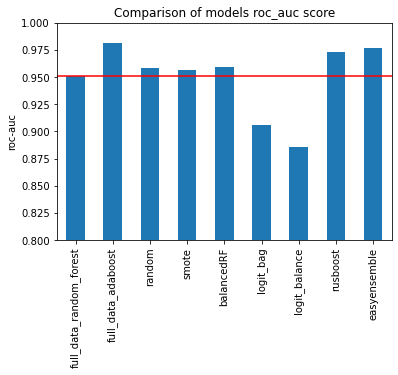

In [26]:
pd.Series(results_dict).plot.bar()
plt.title('Comparison of models roc_auc score')
plt.ylabel('roc-auc')
plt.ylim([0.8,1])
plt.axhline(results_dict['full_data_random_forest'], color='r')
plt.show()

# Conclusion:
    1) Boosting performs better than Bagging algorithms.
    2) Logistic Regression Bagging is worser than random forest (ie decision tree bagging).
    3) random_undersampling and smote_oversampling only marginally improves the roc_auc for Random forest.
    4) For Boosting, resampling doesn't efect the roc_auc that much, hence vanilla boosting models can be used.